In [1]:
import numpy as np
from PySDM.physics.constants import si
from PySDM_examples.Luettmer_homogeneous_freezing.commons import run_simulations, hom_pure_droplet_freezing_backend, hom_pure_droplet_freezing_standard_setup
from PySDM_examples.Luettmer_homogeneous_freezing.simulation import Simulation
from PySDM_examples.Luettmer_homogeneous_freezing.settings import Settings
from PySDM_examples.Luettmer_homogeneous_freezing import plot
from importlib import reload
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [33]:
""" General settings """
hom_freezing_types     = [  "KoopMurray2016", "Spichtinger2023" ]
hom_freezing_types_all = [  "KoopMurray2016", "Spichtinger2023", "Koop2000"  ]
number_of_nsd = (1e1, 1e2, 1e3)
vertical_updrafts = np.geomspace(0.2,10,num=9) * si.meter / si.second
number_concentrations = np.geomspace(100, 20000, num=10) / si.cm ** 3

backends = hom_pure_droplet_freezing_backend()
standard = hom_pure_droplet_freezing_standard_setup()

# Do additional simulations and plots for testing
calc_and_show_bulk_plots = False

In [ ]:
""" High output step reference simulations """
if calc_and_show_bulk_plots:
    setting_dict = {
                **standard,
                "backend": backends["KoopMurray2016"],
                "hom_freezing": "KoopMurray2016",
                "w_updraft": 2.5,
                "deposition_enable": False,
                "n_output": 1
                }
    KoopMurray2016_reference_high_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_high_w_simulation, " without vapor deposition")
    show_plot("fig_KM16_high_w_no_dep")

    setting_dict = {
                **standard,
                "backend": backends["Spichtinger2023"],
                "hom_freezing": "Spichtinger2023",
                "w_updraft": 2.5,
                "deposition_enable": False,
                "n_output": 1,
                "dz": 0.1,
                }
    Spichtinger2023_reference_high_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(Spichtinger2023_reference_high_w_simulation, " without vapor deposition")
    show_plot("fig_SP23_high_w_no_dep")

    setting_dict = {
                **standard,
                "backend": backends["KoopMurray2016"],
                "hom_freezing": "KoopMurray2016",
                "w_updraft": 0.2,
                "deposition_enable": False,
                "n_output": 1,
                "dz": 0.1,
                }
    KoopMurray2016_reference_low_w_simulation = run_simulations(setting_dict)
    plot.plot_thermodynamics_and_bulk(KoopMurray2016_reference_low_w_simulation, " without vapor deposition")
    show_plot("fig_KM16_low_w_no_dep")

In [35]:
""" Simulations for n_sd ensemble without deposition """
nsd_ensemble_no_deposition = {}
nsd_ensemble_no_deposition["ens_variable"] = number_of_nsd
nsd_ensemble_no_deposition["ens_variable_name"] = "n_sd"
nsd_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    nsd_ensemble_no_deposition[hom_freezing_type] = []
    for n_sd in number_of_nsd:
        setting_dict = {
            **standard,
            "n_sd": int(n_sd),
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "number_of_ensemble_runs": 5,
            "deposition_enable": False,
            }
        nsd_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=100 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=10

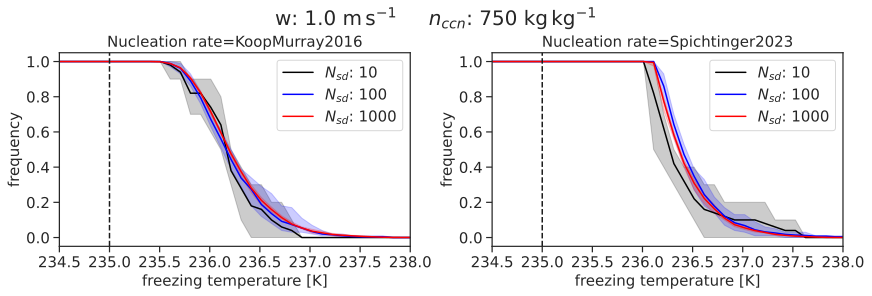

In [86]:
reload(plot)
fig, axs = pyplot.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle("w: "+str(standard["w_updraft"])+r" $\mathrm{m \, s^{-1}}$"+r"     $n_{ccn}$: "+str(750)+r" $\mathrm{kg \, kg^{-1}}$",fontsize=20)
axs = axs.ravel()
for i, hom_freezing_type in enumerate(hom_freezing_types):
    simulations = nsd_ensemble_no_deposition[hom_freezing_type]
    axs[i] = plot.plot_freezing_temperatures_histogram_allinone(axs[i], simulations)
show_plot("n_sd_ensemble_without_deposition")

In [12]:
""" Updraft ensemble simulations without deposition  """
updraft_ensemble_no_deposition = {}
updraft_ensemble_no_deposition["ens_variable"] = vertical_updrafts
updraft_ensemble_no_deposition["ens_variable_name"] = "w_updraft"
updraft_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    updraft_ensemble_no_deposition[hom_freezing_type] = []
    for updraft in vertical_updrafts:
        setting_dict = {
            **standard,
            "w_updraft": updraft  * si.meter / si.second,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
            }
        updraft_ensemble_no_deposition[hom_freezing_type].append( run_simulations(setting_dict) )

Setting up simulation for KoopMurray2016 with wpdraft=0.2 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.32613788179066194 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.5318295896944989 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=0.8672488792828036 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.4142135623730951 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=2.306143078159937 and n_sd=1000 and n_dv=749999999.9999999
Starting simulation...
all particles froz

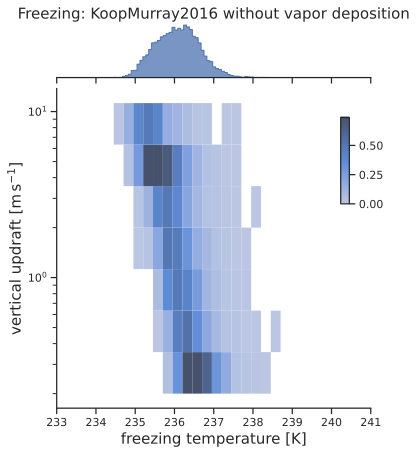

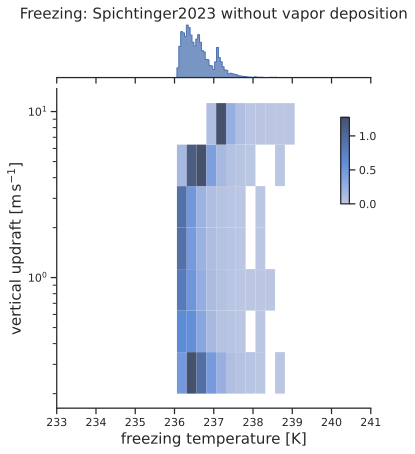

In [41]:
""" Plot ensemble simulations without deposition  """
for hom_freezing_type in hom_freezing_types:

    plot.plot_freezing_temperatures_2d_histogram_seaborn(updraft_ensemble_no_deposition, hom_freezing_type, title_add = " without vapor deposition")

    show_plot(hom_freezing_type+"_updraft_ensemble_no_deposition")

In [40]:
""" Simulations for CCN concentration histogram  """
ccn_ensemble_no_deposition = {}
ccn_ensemble_no_deposition["ens_variable"] = number_concentrations
ccn_ensemble_no_deposition["ens_variable_name"] = "n_ccn"
ccn_ensemble_no_deposition["hom_freezing_types"] = hom_freezing_types

for hom_freezing_type in hom_freezing_types:
    ccn_ensemble_no_deposition[hom_freezing_type] = []
    for n_dv in number_concentrations:
        setting_dict = {
            **standard,
            "N_dv_droplet_distribution": n_dv,
            "backend": backends[hom_freezing_type],
            "hom_freezing": hom_freezing_type,
            "deposition_enable": False,
        }
        ccn_ensemble_no_deposition[hom_freezing_type].append(run_simulations(setting_dict))

Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=99999999.99999999
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=180164823.06544116
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=324593634.7020169
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=584803547.6425728
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=1053610276.8906642
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1.0 and n_sd=1000 and n_dv=1898235091.1593704
Starting simulation...
all particles frozen or evaporated
Setting up simulation for KoopMurray2016 with wpdraft=1

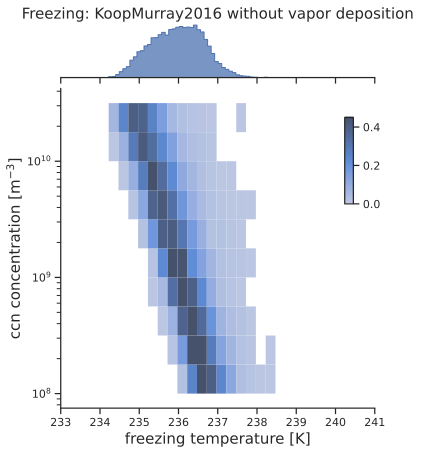

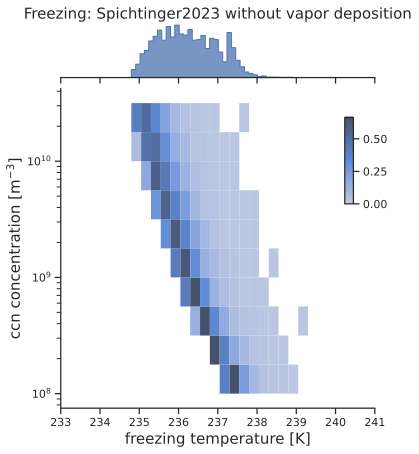

In [88]:
reload(plot)
for hom_freezing_type in hom_freezing_types:

    plot.plot_freezing_temperatures_2d_histogram_seaborn(ccn_ensemble_no_deposition, hom_freezing_type, title_add = " without vapor deposition")

    show_plot(hom_freezing_type+"_radius_ensemble_without_deposition")